<img style="float: right;" src="./img/es2_logo_tiny.jpg"></img>

<h1 align="center">RGB Composition Tool - Planetary Sciences</h1>
<h3 align="center">Example of creating CRISM products</h3>
<hr>

<a href="./Monthly-averages_climate_sciences.ipynb"><< 04-Global monthly anomalies - Climate Sciences </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./OWSlib_for_WCS_2.0.ipynb">06-OWSlib library adaptation to WCS2.0 >></a>

### Background

One of the main focus on planetary science is to characterize the surface mineralogy of planetary bodies. In order to achieve it we use hyperspectral imagery, which acquire a wider electromagnetic range thus showing more information. For Mars different imagery exist being CRISM (Compact Reconnaissance Image Spectometer for Mars) one of the most important. The CRISM dataset is formed by 2 sets of observations: the S observations ranging from 0.3 to 1 microns and containging 107 bands and  the L obervations ranging from 1 to 4 microns contianing 438 bands. In our case we only use the L observations. 

Looking for mineralogy in CRISM images is pursued using a propietary software called ENVI. Here we present a processing pipeline to create the so called CRISM products used to characterize minerals. 


### Addressed community

* of interest across all Planetary Science community specially the one working with hyperpectral imagery

### Benefits

Web Coverage Service 2.0 with its processing extension Web Coverage Processing Service (WCPS) offers an efficient band math computation without data download.

<hr>

## EXAMPLE: Creating an RGB Combination using CRISM products

### Description

RGB combinations of CRISM products are commonly used to characterize the mineralogy of a certain location

<h3>Data required</h3>
<div class="alert alert-info">
<ul type="square">
<li><a href="http://pds-geosciences.wustl.edu/missions/mro/crism.htm">CRISM</a> TRDR data - athmospherically corrected and map projected</li>
<li><b>Format:</b> GeoTIF</li>
<li><b>Spatial resolution:</b> Pixel size 30 x 30 meters</li>
<li><b>Data volume:</b> ~ 150 MB per image</li>
</ul>
</div>

<h3> Workflow </h3>
<div class="alert alert-success">
<ul type="square">
<li>(1) Select the CoverageID and the 3 CRISM products to combine in the RGB combination</li>
<li>(2) Calculate the band math of the RGB combination</li>
<li>(3) Plot the ouput image</li>
</ul>
</div>

### Alternative 

The alternative to the computation of RGB combinations with CRISM prodcuts is entirely done using the proprietary software ENVI, making necessary the purchase of a license.
<hr>

#### Load and Run the planetserver python API

In [3]:
import numpy as np

import re

from astropy.io import fits

# reading the data from the bands_table.fits file

hdulist = fits.open("bands_table.fits")
tabledata = hdulist[1].data # assuming the first extension is a table

cols = hdulist[1].columns

band_name = tabledata["band_name"]
WV = tabledata["wavelength"]

In [4]:
def find_WV_bandname(w):
    # extract wavelength from color name e.g. R295 --> 2950 nanometer --> 2.95 micrometer
    l = float(re.findall("\d+", w)[0])/1000 # converting into micrometer
    
    # nearest wavelength and the corresponding band name index of the given color
    idx = (np.abs(WV-l)).argmin()
    
    # return the corresponding values
    return WV[idx], band_name[idx]

color = "R2260"

#print("Corresponding wavelength and bandname of", color ,": WV =", find_WV_bandname(color)[0],"; Band name", find_WV_bandname(color)[1])

In [5]:
# family f1 is of the formuation : 1-(Rc/(a*Rs+b*Rl)

def f1(lst = []):
    # lst has the arguments Rc, Rs, Rl
    WV_c , bn_c = find_WV_bandname(lst[0]) # Rc
    WV_s , bn_s  = find_WV_bandname(lst[1]) # Rs
    WV_l , bn_l  = find_WV_bandname(lst[2]) # Rl

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[0], bn_c, lst[1], bn_s, lst[2], bn_l))    
        
    b = (WV_c - WV_s) / (WV_l - WV_s)
    a = 1-b
    
    ##########################################################################
    # not correct as bandname is just a place holder for the real values
    val = 1-(bn_c/(a*bn_s + b*bn_l))
    ##########################################################################
    
    # WCPS query as given by the computed product
    F = "1 - (data.band_"+str(bn_c)+" / (("+str(a)+") * data.band_"+str(bn_s)+" + ("+str(b)+") * data.band_"+str(bn_l)+"))"
    
    # strecthed value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    #print("a =", a, " b =", b, " val =", val)
    
    return a, b, val, FS

In [6]:
def URL_creator(coverage_id, red, green, blue, products):
    # Takes the coverage_id, the bands in red, green and blue and computes their corresponding
    # products by looking up from the passed dictionary "products"
    
    F1 = products[red][0](products[red][1])[3]
    F2 = products[green][0](products[green][1])[3]
    F3 = products[blue][0](products[blue][1])[3]
    
    URL = "http://access.planetserver.eu:8090/python?wcpsQuery=http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for data in ( "+coverage_id+" ) return encode({ red: "+F1+";green: "+F2+";blue: "+F3+";alpha: (float)((data.band_100 > 0) * 255)}, \"tiff\", \"nodata=65535\")"
    
    return URL

In [7]:
summary_products = { "BD1300" : [f1, ["R1320", "R1080", "R1750"]], "BD1400" : [f1, ["R1395", "R1330", "R1467"]],
                   "BD1435" : [f1, ["R1435", "R1370", "R1470"]], "BD1500_2" : [f1, ["R1525", "R1367", "R1808"]],
                   "BD1750" : [f1, ["R1750", "R1550", "R1815"]], "BD1750_2" : [f1, ["R1750", "R1690", "R1815"]],
                   "BD2100_2" : [f1, ["R2132", "R1930", "R2250"]], "BD2165" : [f1, ["R2165", "R2120", "R2230"]],
                    "BD2190" : [f1, ["R2185", "R2120", "R2250"]], "BD2210" : [f1, ["R2210", "R2120", "R2250"]],
                    "BD2210_2" : [f1, ["R2210", "R2165", "R2250"]], "BD2230" : [f1, ["R2235", "R2210", "R2252"]],
                    "BD2250" : [f1, ["R2245", "R2120", "R2340"]], "BD2265" : [f1, ["R2265", "R2210", "R2340"]],
                    "BD2290" : [f1, ["R2290", "R2250", "R2350"]], "BD2355" : [f1, ["R2355", "R2300", "R2450"]],
                    "BD2500_2" : [f1, ["R2480", "R2364", "R2570"]], "BD3100" : [f1, ["R3120", "R3000", "R3250"]],
                    "BD3200" : [f1, ["R3320", "R3250", "R3390"]], "BD3400_2" : [f1, ["R3420", "R3250", "R3630"]],
                    "BD2600" : [f1, ["R2600", "R2530", "R2630"]] }

#key = "BD2600"
#a, b, val, F1 = summary_products[key][0](summary_products[key][1])

#### (1) Select the CoverageID and the 3 CRISM products to combine in the RGB combination

In [8]:
covID = "frt0000a053_07_if166l_trr3"
red_prod = "BD1400"
green_prod = "BD1500_2"
blue_prod = "BD3100"

#### (2) Calculate the band math of the RGB combination

In [11]:
URL = URL_creator(covID, red_prod, green_prod, blue_prod, summary_products)

print(URL)

http://access.planetserver.eu:8090/python?wcpsQuery=http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for data in ( frt0000a053_07_if166l_trr3 ) return encode({ red: (float)((int)( 255 / ( max(1 - (data.band_61 / ((0.523885465748) * data.band_51 + (0.476114534252) * data.band_72))) - min(1 - (data.band_61 / ((0.523885465748) * data.band_51 + (0.476114534252) * data.band_72))) )) * ( (1 - (data.band_61 / ((0.523885465748) * data.band_51 + (0.476114534252) * data.band_72))) - min(1 - (data.band_61 / ((0.523885465748) * data.band_51 + (0.476114534252) * data.band_72))) ));green: (float)((int)( 255 / ( max(1 - (data.band_81 / ((0.642179772222) * data.band_57 + (0.357820227778) * data.band_124))) - min(1 - (data.band_81 / ((0.642179772222) * data.band_57 + (0.357820227778) * data.band_124))) )) * ( (1 - (data.band_81 / ((0.642179772222) * data.band_57 + (0.357820227778) * data.band_124))) - min(1 - (data.band_81 / ((0.642179772222) * da

##### (3) Plot the ouput image

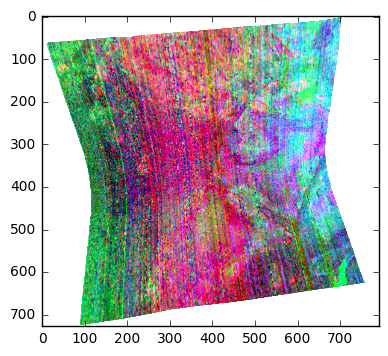

In [12]:
%matplotlib inline
import urllib2
import matplotlib.pyplot as plt

f=urllib2.urlopen("http://access.planetserver.eu:8090/python?wcpsQuery=http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for%20data%20in%20(%20frt0000a053_07_if166l_trr3%20)%20return%20encode(%7B%20red%3A%20(float)((int)(%20255%20%2F%20(%20max(1%20-%20(data.band_61%20%2F%20((0.523885465748)%20*%20data.band_51%20%2B%20(0.476114534252)%20*%20data.band_72)))%20-%20min(1%20-%20(data.band_61%20%2F%20((0.523885465748)%20*%20data.band_51%20%2B%20(0.476114534252)%20*%20data.band_72)))%20))%20*%20(%20(1%20-%20(data.band_61%20%2F%20((0.523885465748)%20*%20data.band_51%20%2B%20(0.476114534252)%20*%20data.band_72)))%20-%20min(1%20-%20(data.band_61%20%2F%20((0.523885465748)%20*%20data.band_51%20%2B%20(0.476114534252)%20*%20data.band_72)))%20))%3Bgreen%3A%20(float)((int)(%20255%20%2F%20(%20max(1%20-%20(data.band_81%20%2F%20((0.642179772222)%20*%20data.band_57%20%2B%20(0.357820227778)%20*%20data.band_124)))%20-%20min(1%20-%20(data.band_81%20%2F%20((0.642179772222)%20*%20data.band_57%20%2B%20(0.357820227778)%20*%20data.band_124)))%20))%20*%20(%20(1%20-%20(data.band_81%20%2F%20((0.642179772222)%20*%20data.band_57%20%2B%20(0.357820227778)%20*%20data.band_124)))%20-%20min(1%20-%20(data.band_81%20%2F%20((0.642179772222)%20*%20data.band_57%20%2B%20(0.357820227778)%20*%20data.band_124)))%20))%3Bblue%3A%20(float)((int)(%20255%20%2F%20(%20max(1%20-%20(data.band_314%20%2F%20((0.526564297901)%20*%20data.band_296%20%2B%20(0.473435702099)%20*%20data.band_334)))%20-%20min(1%20-%20(data.band_314%20%2F%20((0.526564297901)%20*%20data.band_296%20%2B%20(0.473435702099)%20*%20data.band_334)))%20))%20*%20(%20(1%20-%20(data.band_314%20%2F%20((0.526564297901)%20*%20data.band_296%20%2B%20(0.473435702099)%20*%20data.band_334)))%20-%20min(1%20-%20(data.band_314%20%2F%20((0.526564297901)%20*%20data.band_296%20%2B%20(0.473435702099)%20*%20data.band_334)))%20))%3Balpha%3A%20(float)((data.band_100%20%3E%200)%20*%20255)%7D%2C%20%22tiff%22%2C%20%22nodata%3D65535%22)")

# read the image file in a numpy array
a = plt.imread(f)
plt.imshow(a)
plt.show()

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>